In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def pooled_variance_and_mean(varss, counts, mus):
    pooled_mu = 0
    denom = np.sum(counts)
    for mu, count in zip(mus, counts):
        pooled_mu += (mu * count)
    pooled_mu /= denom
    
    numerator = 0 
    for mu, var,count in zip(mus, varss, counts):
        numerator += count * (var + mu)
    pooled_var = (numerator/denom) - pooled_mu
        
    return pooled_mu, pooled_var, denom 

In [3]:
def exclude_runs(df):
    '''Runs lasting less than 15000 ticks should be excluded. Returns a DataFrame with these runs removed. Also removes runs with primitive exceptions'''
    
    df= df.astype(str)
    df.replace({'<RuntimePrimitiveException>':np.nan}, inplace = True)
    df = df.astype(float)


    run_col =''
    for col in df.columns:
        df = df[~df[col].isnull()]
        
        if 'run number' in col:
            run_col = col
    counts = df[['ticks', run_col]].groupby(run_col).count()
   
    to_exclude = []
    for i in set(df[run_col]):
        if list(counts['ticks'])[int(i)-1] < 15000:
            to_exclude.append(i)
            
    df = df[~df[run_col].isin(to_exclude)]
    df.rename(columns={run_col:'run_number'}, inplace  = True)
    return df

In [4]:
filenames = ['FlockingBase400 experiment-table', 'FlockingBase400 pt2 experiment-table','FlockingBase400 pt3 experiment-table',
            'FlockingBase400 pt 4 experiment-table', 'FlockingBase400 pt5 experiment-table', 'FlockingBase400 pt 6 experiment-table',
            'FlockingBase400 pt 7 experiment-table']
frames = []
for file in filenames:
    temp = pd.read_csv(file, low_memory = False)
    temp.drop(['kill-probability', 'kill-radius', 'population', 'kill-angle', '[step]'], axis = 1, inplace = True)
    temp = exclude_runs(temp)
    frames.append(temp)
    
combined = pd.concat(frames)
combined.columns = ['run_number', 'n_birds', 'ticks', 'mean_detection_radius', 'var_detection_radius',
                   'mean_detection_angle', 'var_detection_angle', 'mean_escape_angle', 'var_escape_angle',
                   'mean_escape_velocity', 'var_escape_velocity', 'mean_neighbor', 'var_neighbor']
combined = combined.astype(float)

print('Total n trials:',len(combined)/15001) #number of trials
combined.head()


Total n trials: 32.0


,run_number,n_birds,ticks,mean_detection_radius,var_detection_radius,mean_detection_angle,var_detection_angle,mean_escape_angle,var_escape_angle,mean_escape_velocity,var_escape_velocity,mean_neighbor,var_neighbor
0,3.0,400.0,0.0,4.525000,8.711153,180.510000,10437.067569,93.150000,2670.488722,1.997675,0.342207,2.880000,2.166015
1,1.0,400.0,0.0,4.505000,8.255614,177.800000,10748.481203,89.347500,2641.510520,1.981175,0.344394,2.970000,1.938947
4,3.0,392.0,1.0,4.474490,8.695000,179.107143,10447.973146,92.002551,2651.956515,1.985893,0.341136,2.892857,2.157289
6,1.0,397.0,1.0,4.473552,8.184273,177.415617,10743.531372,88.755668,2614.371969,1.979899,0.346727,2.962217,1.940488
9,3.0,383.0,2.0,4.391645,8.573961,175.913838,10194.377373,91.472585,2684.030006,1.983995,0.343618,2.898172,2.159761


C:\Users\Benji\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\Benji\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


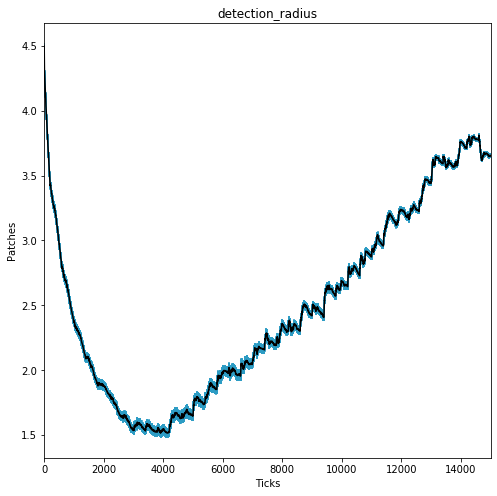

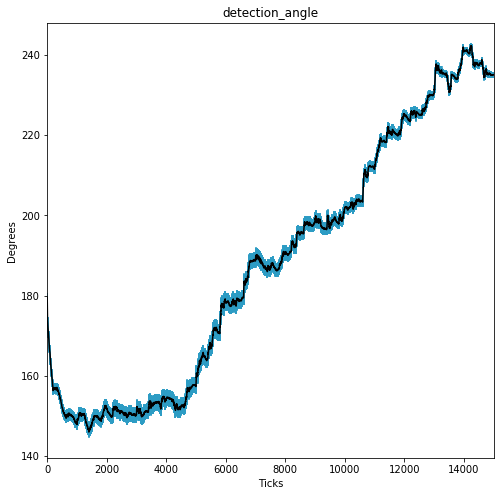

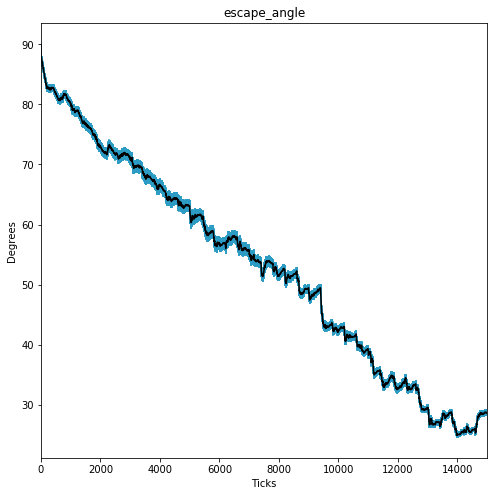

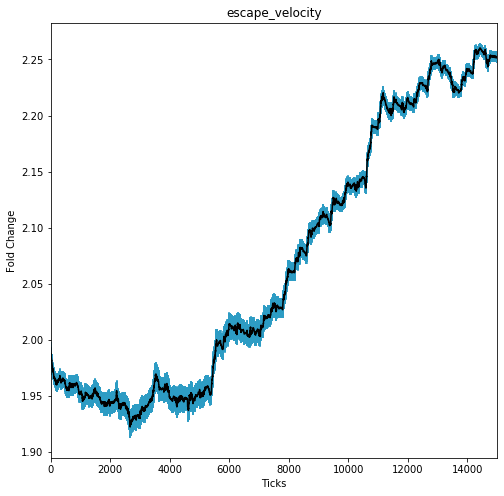

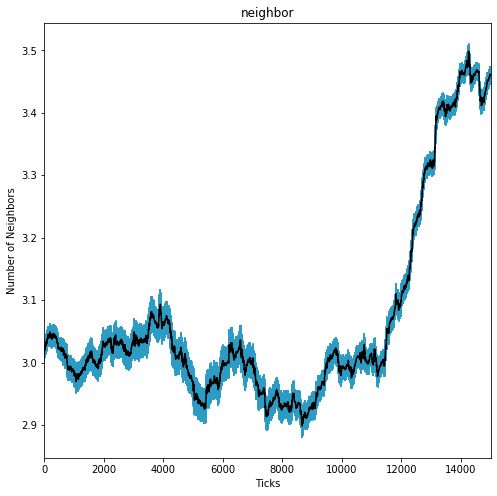

In [5]:
sensitivity_types = ['detection_radius', 'detection_angle', 'escape_angle', 'escape_velocity', 'neighbor']
units = ['Patches', 'Degrees', 'Degrees', 'Fold Change', 'Number of Neighbors']

for s_type, unit in zip(sensitivity_types, units):
    mus = []
    sems = []
    for i in range(0, 15002):
        temp = combined[ combined['ticks'] == float(i)]
#         print(temp, i)
        means_list = temp['mean_' + s_type]
        vars_list = temp['var_' + s_type]
        counts_list = temp['n_birds']
        
        pooled_mu, pooled_var, count = pooled_variance_and_mean(vars_list,counts_list, means_list)
        sem = np.sqrt(pooled_var)/np.sqrt(count)
        mus.append(pooled_mu)
        sems.append(sem)
        
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    ax.errorbar(x = range(15002), y = mus, yerr = sems, color = 'black',ecolor = '#2d9cc4')
    ax.set_xlim([0, 15000])
    ax.set_title(s_type)
    ax.set_xlabel('Ticks')
    ax.set_ylabel(unit)
    filename = s_type + '2.png'
    plt.savefig(filename)

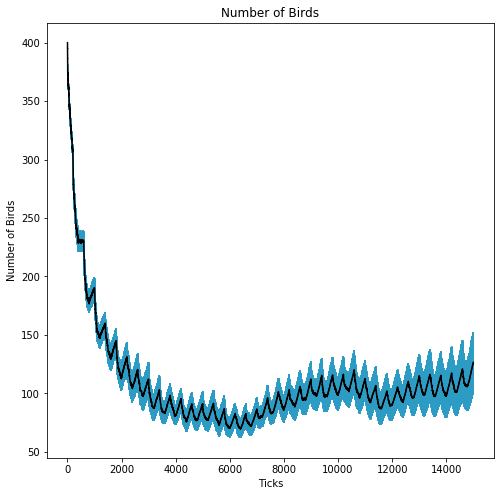

In [6]:
means= combined[['ticks', 'n_birds']].groupby('ticks').mean()['n_birds']
stdev = np.sqrt(combined[['ticks', 'n_birds']].groupby('ticks').var()['n_birds'])
sqrt_count = np.sqrt(combined[['ticks', 'n_birds']].groupby('ticks').count()['n_birds'])
sem = stdev/sqrt_count

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.errorbar(x = range(len(means)), y = means, yerr = sem, color = 'black',ecolor = '#2d9cc4')
ax.set_title('Number of Birds')
ax.set_xlabel('Ticks')
ax.set_ylabel('Number of Birds')
filename = 'BirdsOverTime3.png'
plt.savefig(filename)
